In [1]:
# -*- coding: utf-8 -*-
#%% NumPyの読み込み
import numpy as np
#   SciPyのstatsモジュールの読み込み
import scipy.stats as st
#   SciPyのLinalgモジュールの読み込み
import scipy.linalg as la
#   PyMCの読み込み
import pymc3 as pm
#   MatplotlibのPyplotモジュールの読み込み
import matplotlib.pyplot as plt
#   日本語フォントの設定
from matplotlib.font_manager import FontProperties
import sys
if sys.platform.startswith('win'):
    FontPath = 'C:\\Windows\\Fonts\\meiryo.ttc'
elif sys.platform.startswith('darwin'):
    FontPath = '/System/Library/Fonts/ヒラギノ角ゴシック W4.ttc'
elif sys.platform.startswith('linux'):
    FontPath = '/usr/share/fonts/truetype/takao-gothic/TakaoPGothic.ttf'
else:
    print('このPythonコードが対応していないOSを使用しています．')
    sys.exit()
jpfont = FontProperties(fname=FontPath)

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
#%% 回帰モデルからのデータ生成
n = 50
np.random.seed(99)
u = st.norm.rvs(scale=0.7, size=n)
x = st.uniform.rvs(loc=-np.sqrt(3.0), scale=2.0*np.sqrt(3.0), size=n)
y = 1.0 + 2.0 * x + u
#%% 回帰モデルの係数と誤差項の分散の事後分布の設定（自然共役事前分布）
b0 = np.zeros(2)
A0 = 0.2 * np.eye(2)
nu0 = 5.0
lam0 = 7.0
h0 = np.sqrt(np.diag(lam0 / nu0 * la.inv(A0)))
sd0 = np.sqrt(np.diag(la.inv(A0)))
regression_conjugate = pm.Model()
with regression_conjugate:
    sigma2 = pm.InverseGamma('sigma2', alpha=0.5*nu0, beta=0.5*lam0)
    sigma = pm.math.sqrt(sigma2)
    a = pm.Normal('a', mu=b0[0], sigma=sigma*sd0[0])
    b = pm.Normal('b', mu=b0[1], sigma=sigma*sd0[1])
    y_hat = a + b z* x
    likelihood = pm.Normal('y', mu=y_hat, sigma=sigma, observed=y)

In [ ]:
regresssion_normal_invgamma = pm.Model()
with regresssion_normal_invgamma:
    sigma2 = pm.InverseGamma('sigma2', alpha=0.5*nu0, beta=0.5*lam0)
    a = pm.Normal('a', mu=0.0, sigma=sd0[0])
    b = pm.Normal('b', mu=0.0, sigma=sd0[1])
    y_hat = a + b * x
    likelihood = pm.Normal('y', mu=y_hat, sigma=pm.math.sqrt(sigma2),observed=y)

In [4]:
n_draws = 5000
n_chains = 4
n_tune = 1000
with regression_conjugate:
    trace = pm.sample(draws=n_draws, chains=n_chains, tune=n_tune,
                      random_seed=123)
    print(pm.summary(trace))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, sigma2]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 235 seconds.
         mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean   ess_sd  \
a       0.999  0.109   0.796    1.203      0.001    0.000   24204.0  23964.0   
b       2.002  0.112   1.794    2.218      0.001    0.001   24559.0  24431.0   
sigma2  0.586  0.116   0.390    0.808      0.001    0.001   22885.0  20753.0   

        ess_bulk  ess_tail  r_hat  
a        24234.0   14977.0    1.0  
b        24582.0   14512.0    1.0  
sigma2   23443.0   12914.0    1.0  


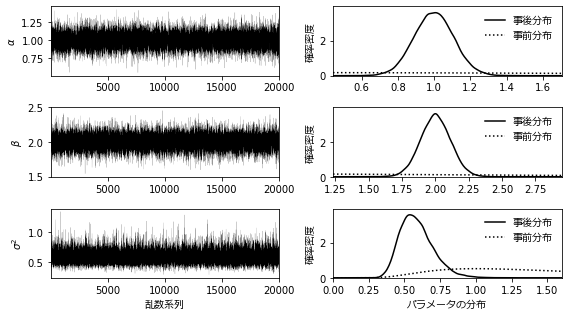

In [5]:
#%% 事後分布のグラフの作成
k = b0.size
param_names = ['a', 'b', 'sigma2']
labels = ['$\\alpha$', '$\\beta$', '$\\sigma^2$']
fig, ax = plt.subplots(k+1, 2, num=1, figsize=(8, 1.5*(k+1)), facecolor='w')
for index in range(k+1):
    mc_trace = trace[param_names[index]]
    if index < k:
        x_min = mc_trace.min() - 0.2 * np.abs(mc_trace.min())
        x_max = mc_trace.max() + 0.2 * np.abs(mc_trace.max())
        x = np.linspace(x_min, x_max, 250)
        prior = st.norm.pdf(x, loc=b0[index], scale=sd0[index])
    else:
        x_min = 0.0
        x_max = mc_trace.max() + 0.2 * np.abs(mc_trace.max())
        x = np.linspace(x_min, x_max, 250)
        prior = st.invgamma.pdf(x, 0.5*nu0, scale=0.5*lam0)
        ax[index, 0].set_xlabel('乱数系列', fontproperties=jpfont)
        ax[index, 1].set_xlabel('パラメータの分布', fontproperties=jpfont)
    ax[index, 0].plot(mc_trace, 'k-', linewidth=0.1)
    ax[index, 0].set_xlim(1, n_draws*n_chains)
    ax[index, 0].set_ylabel(labels[index], fontproperties=jpfont)
    posterior = st.gaussian_kde(mc_trace).evaluate(x)
    ax[index, 1].plot(x, posterior, 'k-', label='事後分布')
    ax[index, 1].plot(x, prior, 'k:', label='事前分布')
    ax[index, 1].set_xlim(x_min, x_max)
    ax[index, 1].set_ylim(0, 1.1*posterior.max())
    ax[index, 1].set_ylabel('確率密度', fontproperties=jpfont)
    ax[index, 1].legend(loc='best', frameon=False, prop=jpfont)
plt.tight_layout()
plt.savefig('pybayes_fig_mcmc_reg_ex1.png', dpi=300)
plt.show()
